<span STYLE="font-size:150%"> 
    Segment microCT scans
</span>

Docker image: gnasello/slicer-env:2023-07-06 \
Latest update: 10 March 2023

- load image stack in Slicer
- segment mineralized tissue
- compute segmented statistics (volumes)

# Load libraries

In [1]:
import pyslicer as ps
import slicer
from pathlib import Path
import pandas as pd

# Volume input

## Load `.nrrd` file into 3D Slicer

Write the path of the `.nrrd` file and load it to Slicer

In [10]:
# this cell is tagged 'parameters'
volume_file = 'microCT_volume/microCT_volume.nrrd'
output_dir_path = 'segmented_volumes'
segmentMask_file = 'segmented_volumes/Segment_mask.seg.nrrd'

In [3]:
path = Path(volume_file)

# Remove image numbering _0000, _0001 ...
filename_output = path.stem[:-4]

In [4]:
masterVolumeNode = slicer.util.loadNodeFromFile(volume_file)

Print spacing

In [5]:
## mm
masterVolumeNode.GetSpacing()

(0.0078528, 0.0078528, 0.0078528)

Make ```segmented_volumes``` folder

In [6]:
output_directory = Path(output_dir_path)

output_directory.mkdir(parents=True, exist_ok=True)

## Adjust window/level (brightness/contrast)

Adjust the image window/level from the GUI. It is enough to select a region where the signal is present ([youtube](https://slicer.readthedocs.io/en/latest/user_guide/user_interface.html#adjusting-image-window-level)). 

After, get the Window and Level properties from the displayNode associate to the VolumeNode and apply them programmatically anytime you run again the same image.

For more information on the relationship between window/level and brightness/contrast, see [Window and Level Contrast Enhancement](http://fisica.ciens.ucv.ve/curs/dipcourse/html/one-oper/window-level/front-page.html)

In [7]:
displayNode = masterVolumeNode.GetDisplayNode()
print('displayNode.SetWindow(' + str(displayNode.GetWindow()) + ')')
print('displayNode.SetLevel(' + str(displayNode.GetLevel()) + ')')

displayNode.SetWindow(25152.0)
displayNode.SetLevel(20991.0)


In [8]:
# displayNode = masterVolumeNode.GetDisplayNode()
# displayNode.AutoWindowLevelOff()
# displayNode.SetWindow(25885.0)
# displayNode.SetLevel(18464.5)

# Create segmentationNode

## Create segmentation-related nodes

Create segmentation node

In [13]:
segmentationNode = ps.segmentation.segmentationNode(name='Segmentation')

Create temporary segment editor to get access to effects

In [14]:
segmentEditorWidget, segmentEditorNode = ps.segmentation.segmentEditorWidget(segmentationNode = segmentationNode, 
                                                                             masterVolumeNode = masterVolumeNode)

## Load Segment Mask LabelmapNode

Load segmentation from .nrrd file as labelmap node slicer util module to load from File [github](https://github.com/Slicer/Slicer/blob/master/Base/Python/slicer/util.py#L341-L344)

In [11]:
# Load segmentation from .seg.nrrd file (includes segment names and colors)

segmentMask_labelmap = slicer.util.loadNodeFromFile(segmentMask_file, 'VolumeFile', properties={'labelmap':True})
# segmentationNode = slicer.util.loadSegmentation(file_nuclei_segmentation)

Import SegmentMask labelmapNode to segmentationNode

In [15]:
slicer.modules.segmentations.logic().ImportLabelmapToSegmentationNode(segmentMask_labelmap, segmentationNode)

True

Rename segment of the segmentation node 

In [16]:
segmentation = segmentationNode.GetSegmentation()
segment = segmentation.GetNthSegment(0)
segment.SetName("SegmentMask")

Delete bone labelmapNode

In [17]:
slicer.mrmlScene.RemoveNode(segmentMask_labelmap)
# masterVolumeNode.SetDisplayVisibility(1)

## Set a mask in segmentation node
[link](https://discourse.slicer.org/t/masking-settings-from-a-script-on-a-segment-editor-effect-in-python/14323/7)

In [18]:
MaskSegment_name = 'SegmentMask'

MaskSegmentID = segmentation.GetSegmentIdBySegmentName(MaskSegment_name)
segmentEditorNode.SetMaskSegmentID(MaskSegmentID)

# Mask Mode 5 means paint only allowed inside one segment
# https://discourse.slicer.org/t/how-can-i-set-masking-settings-on-a-segment-editor-effect-in-python/4406/2
segmentEditorNode.SetMaskMode(5)

# Avoid overwrite of overlapping segments
segmentEditorNode.SetOverwriteMode(slicer.vtkMRMLSegmentEditorNode.OverwriteNone)

# Thresholding

## Check different automatic segmentation algorithms

The first time you analyze an image/channel. Go to the ```Segment Editor```, add a new segment and choose the thresholding method. There you test different automatic thresholding technique and choose the one working best. For later analysis, you can just copy the thresholding values in the ```segments_greyvalues``` object at the beginning of this notebook.

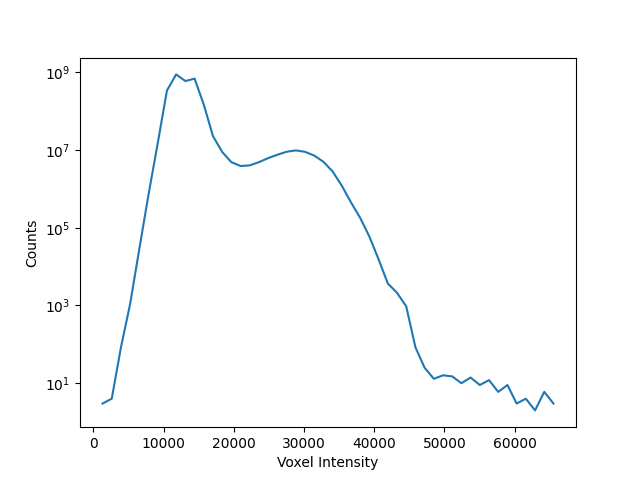

In [19]:
ps.volume.plot_histogram(masterVolumeNode, yscale='log')

Get automatic thresholding values, as indicated in [this script](https://github.com/jzeyl/3D-Slicer-Scripts/blob/db51967cc642837e8bae0fea1585a95074d8420b/load_dicom_modified_otsu.py#L56)

In [20]:
methods = [
            'HUANG',
            'INTERMODES',
            'ISO_DATA',
            'KITTLER_ILLINGWORTH',
            'LI',
            'MAXIMUM_ENTROPY',
            'MOMENTS',
            'OTSU',
            'RENYI_ENTROPY',
            'SHANBHAG',
            'TRIANGLE',
            'YEN'
            ]

thresholds = dict.fromkeys(methods, None)
thresholds

{'HUANG': None,
 'INTERMODES': None,
 'ISO_DATA': None,
 'KITTLER_ILLINGWORTH': None,
 'LI': None,
 'MAXIMUM_ENTROPY': None,
 'MOMENTS': None,
 'OTSU': None,
 'RENYI_ENTROPY': None,
 'SHANBHAG': None,
 'TRIANGLE': None,
 'YEN': None}

Otsu thresholding

In [ ]:
method = 'OTSU'

threshold = ps.segmentation.compute_threshold(method = method, volumeNode = masterVolumeNode)

thresholds[method.upper()] = threshold

print(method + " threshold: " + str(threshold))
ps.volume.plot_histogram(masterVolumeNode, threshold = threshold, title = method, yscale='log')

Huang thresholding

In [ ]:
method = 'HUANG'

threshold = ps.segmentation.compute_threshold(method = method, volumeNode = masterVolumeNode)

thresholds[method.upper()] = threshold

print(method + " threshold: " + str(threshold))
ps.volume.plot_histogram(masterVolumeNode, threshold = threshold, title = method, yscale='log')

IsoData thresholding

In [ ]:
method = 'ISO_DATA'

threshold = ps.segmentation.compute_threshold(method = method, volumeNode = masterVolumeNode)

thresholds[method.upper()] = threshold

print(method + " threshold: " + str(threshold))
ps.volume.plot_histogram(masterVolumeNode, threshold = threshold, title = method, yscale='log')

MAXIMUM_ENTROPY thresholding

In [ ]:
method = 'MAXIMUM_ENTROPY'

threshold = ps.segmentation.compute_threshold(method = method, volumeNode = masterVolumeNode)

thresholds[method.upper()] = threshold

print(method + " threshold: " + str(threshold))
ps.volume.plot_histogram(masterVolumeNode, threshold = threshold, title = method, yscale='log')

MOMENTS thresholding

In [ ]:
method = 'MOMENTS'

threshold = ps.segmentation.compute_threshold(method = method, volumeNode = masterVolumeNode)

thresholds[method.upper()] = threshold

print(method + " threshold: " + str(threshold))
ps.volume.plot_histogram(masterVolumeNode, threshold = threshold, title = method, yscale='log')

INTERMODES thresholding

In [ ]:
method = 'INTERMODES'

threshold = ps.segmentation.compute_threshold(method = method, volumeNode = masterVolumeNode)

thresholds[method.upper()] = threshold

print(method + " threshold: " + str(threshold))
ps.volume.plot_histogram(masterVolumeNode, threshold = threshold, title = method, yscale='log')

## Select thresholding values

In [ ]:
thresholds

In [ ]:
segments_greyvalues = {
    "Bone": [thresholds['MOMENTS']*1.3, 65535], # [MaxEntropy, MaxIntensity]
    }

segments_greyvalues

In [ ]:
grey_df = pd.DataFrame(segments_greyvalues)

outputfile = output_directory / 'segments_greyvalues.csv'
grey_df.to_csv(outputfile, index=False)

## Create segments by thresholding

In [ ]:
ps.segmentation.segments_by_thresholding(segments_greyvalues, 
                                         segmentationNode,
                                         segmentEditorNode,
                                         segmentEditorWidget)

Set segments color

In [ ]:
segments_color = {
    "Bone": (0.9450980392156862, 0.8392156862745098, 0.5686274509803921), # "Bone" color in Slicer
    }

segments_color

In [ ]:
ps.segmentation.set_segments_color(segments_color, segmentationNode)

# Operation on segments

## Manual fix of the segmentation

Sometimes it might be necessary to remove speckles at the image boundaries. If so, use the `scissor` tool in the `Segment Editor` before proceeding with the rest of the script. 

## Remove small islands

REMOVE_SMALL_ISLANDS operation from the [SegmentEditorIslandsEffect](https://github.com/Slicer/Slicer/blob/294ef47edbac2ccb194d5ee982a493696795cdc0/Modules/Loadable/Segmentations/EditorEffects/Python/SegmentEditorIslandsEffect.py#L402)

In [ ]:
# segment_name = 'Bone'
# minimum_size = 20 #number of voxels

In [ ]:
# ps.segmentation.remove_small_islands(minimum_size, 
#                                      segment_name, 
#                                      segmentEditorNode,
#                                      segmentEditorWidget)

## Smoothing thresholded segment

In [ ]:
segment_name = 'Bone'
gaussiaSD_mm = 0.001 #units are in millimiters

In [ ]:
ps.segmentation.gaussian_smoothing(gaussiaSD_mm, 
                                   segment_name, 
                                   segmentEditorNode, 
                                   segmentEditorWidget)

# Export segments

## As seg.nrrd file (labelmap node)

Export a selection of segments (identified by their names), from [slicer tutorial](https://slicer.readthedocs.io/en/latest/developer_guide/script_repository.html#export-labelmap-node-from-segmentation-node)

Bone LabelmapNode

In [ ]:
seg_name = 'Bone'

In [ ]:
mineralized_labelmap = ps.segmentation.individual_segment_to_labelmapNode(segmentName = seg_name,
                                                                          segmentationNode = segmentationNode,
                                                                          volumeNode = masterVolumeNode)

In [ ]:
filename_output = seg_name + '.seg.nrrd'

slicer.util.exportNode(mineralized_labelmap, output_directory / filename_output)

## Convert all segments to model nodes

Get closed surface representation of the segment, from [slicer scripting repository](https://slicer.readthedocs.io/en/latest/developer_guide/script_repository.html#export-nodes-warped-by-transform-sequence)

In [ ]:
segmentationNode.CreateClosedSurfaceRepresentation()

In [ ]:
shNode = slicer.mrmlScene.GetSubjectHierarchyNode()
exportFolderItemId = shNode.CreateFolderItem(shNode.GetSceneItemID(), "Segments")
slicer.modules.segmentations.logic().ExportAllSegmentsToModels(segmentationNode, exportFolderItemId)

## Decimate model node from segmentation node

Get `VTK Polydata` from model

In [ ]:
nodename = 'Bone'
modelNode = slicer.util.getNode(nodename)

Use pyvista to get faces and vertices of the `VTK PolyData` object

In [ ]:
import pyvista as pv

In [ ]:
model_pv = pv.wrap(modelNode.GetPolyData())
vertices = model_pv.points
faces = model_pv.regular_faces

Import pyvista object to pymeshlab, which performs more efficient decimation than VTK

Check how to [import mesh from arrays in meshlab](https://pymeshlab.readthedocs.io/en/0.1.9/tutorials/import_mesh_from_arrays.html)

In [ ]:
import pymeshlab 
# create a new Mesh with the two arrays
model_ml = pymeshlab.Mesh(vertices, faces)

# create a new MeshSet
mesh_set = pymeshlab.MeshSet()

# add the mesh to the MeshSet
mesh_set.add_mesh(model_ml, "mesh")

print('input mesh has', model_ml.vertex_number(), 'vertex and', model_ml.face_number(), 'faces')

Decimate mesh with `pymeshlab`, from [stackoverflow](https://stackoverflow.com/questions/75169329/how-to-use-pymeshlab-to-reduce-number-of-faces-to-a-guaranteed-specific-number)

In [ ]:
decimation_factor = 0.2

#Target number of vertex
TARGET = round(model_ml.vertex_number() * decimation_factor)

#Reduce to TARGET. Sometimes will fall into TARGET-1
mesh_set.meshing_decimation_quadric_edge_collapse(targetfacenum=TARGET, preservenormal=True)

model_ml = mesh_set.current_mesh()
print('output mesh has', model_ml.vertex_number(), 'vertex and', model_ml.face_number(), 'faces')

Load decimated model to Slicer

In [ ]:
vertices = model_ml.vertex_matrix()
faces = model_ml.face_matrix()
model_decimated = pv.PolyData.from_regular_faces(vertices, faces)

decimatedNode = slicer.modules.models.logic().AddModel(model_decimated)

## Export decimated model from segmentation node

Export pymeshlab object to .stl file

In [ ]:
filename_output = 'Bone.stl'

slicer.util.exportNode(decimatedNode, output_directory / filename_output)